In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# 데이터 로드 및 전처리
# ===============================
file_path = '/content/2018-2024.xlsx'
df = pd.read_excel(file_path)

cols = ["과일종류", "계절", "국내수입"]
for c in cols:
    df[c] = df[c].astype("category")

x = ["년도", "월", "과일종류", "평균기온", "강수량", "일조시간", "계절", "국내수입"]
y = "판매량(kg)"

train_df = df[df["년도"] <= 2023]
valid_df = df[df["년도"] == 2024]

X_train = train_df[x]
y_train = train_df[y]
X_valid = valid_df[x]
y_valid = valid_df[y]

In [29]:
param_dist = {
    'num_leaves': randint(20, 300),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(200, 1500),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'min_child_samples': randint(5, 100),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# 초기 모델 생성
base_model = LGBMRegressor(
    objective='regression',
    random_state=42,
    verbose=-1
)

# RandomizedSearchCV 실행
grid = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# 최적 파라미터 가져오기
best_params = grid.best_params_
print("최적 파라미터:", best_params)

# 최적 파라미터 적용
model = LGBMRegressor(objective='regression', random_state=42, **best_params)
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=10)
]
evals_result = {}

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric=["rmse", "mae"],
    callbacks=callbacks
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 파라미터: {'colsample_bytree': np.float64(0.6668543055695109), 'learning_rate': np.float64(0.038573363584388155), 'max_depth': 5, 'min_child_samples': 26, 'n_estimators': 969, 'num_leaves': 211, 'reg_alpha': np.float64(0.9922115592912175), 'reg_lambda': np.float64(0.6174815096277165), 'subsample': np.float64(0.8058265802441404)}
Training until validation scores don't improve for 50 rounds
[10]	training's rmse: 8364.92	training's l1: 6685.02	training's l2: 6.99719e+07	valid_1's rmse: 9149.05	valid_1's l1: 7129.23	valid_1's l2: 8.37051e+07
[20]	training's rmse: 7500.46	training's l1: 6005.36	training's l2: 5.62568e+07	valid_1's rmse: 8285.08	valid_1's l1: 6453.63	valid_1's l2: 6.86426e+07
[30]	training's rmse: 6124.22	training's l1: 4893.36	training's l2: 3.75061e+07	valid_1's rmse: 6931.29	valid_1's l1: 5333.86	valid_1's l2: 4.80428e+07
[40]	training's rmse: 5415.69	training's l1: 4294.89	training's l2: 2.93297e+07	valid_1's r

LGBMRegressor(colsample_bytree=np.float64(0.6668543055695109),
              learning_rate=np.float64(0.038573363584388155), max_depth=5,
              min_child_samples=26, n_estimators=969, num_leaves=211,
              objective='regression', random_state=42,
              reg_alpha=np.float64(0.9922115592912175),
              reg_lambda=np.float64(0.6174815096277165),
              subsample=np.float64(0.8058265802441404))

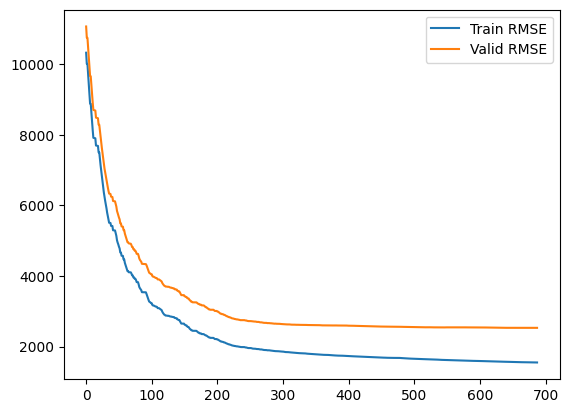

In [30]:
# 과적합 확인
results = model.evals_result_
import matplotlib.pyplot as plt

plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Valid RMSE')
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import mean_absolute_error

# ===============================
#  성능 평가
# ===============================
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# R2
r2_train = r2_score(y_train, y_train_pred)
r2_valid = r2_score(y_valid, y_valid_pred)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))

# MAE ⭐ 추가!
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_valid = mean_absolute_error(y_valid, y_valid_pred)

print(f"Train R² : {r2_train:.3f},  Valid R² : {r2_valid:.3f}")
print(f"Train RMSE: {rmse_train:.3f}, Valid RMSE: {rmse_valid:.3f}")
print(f"Train MAE : {mae_train:.3f}, Valid MAE: {mae_valid:.3f}")  # ⭐


Train R² : 0.978,  Valid R² : 0.950
Train RMSE: 1570.247, Valid RMSE: 2530.951
Train MAE : 1189.966, Valid MAE: 1872.400


In [32]:
# ===============================
#  모델 저장
# ===============================
model_path = "LightGBM_model_2025.pkl"
joblib.dump(model, model_path)
print(f" 모델 저장 완료: {model_path}")



 모델 저장 완료: LightGBM_model_2025.pkl


In [40]:
# ===============================
#  2025년 예상수요량 예측 후 엑셀 저장
# ===============================
future_df = valid_df.copy()
future_df["년도"] = 2025
X_future = future_df[x]
future_df["예상수요량"] = model.predict(X_future)

output_path = "예상수요량_2025예측.xlsx"
future_df.to_excel(output_path, index=False)
print(f" 2025년 예측 결과 엑셀 저장 완료: {output_path}")

 2025년 예측 결과 엑셀 저장 완료: 예상수요량_2025예측.xlsx


In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# lightGBM

*   lightGBM(R) 예상수요량 2025년예측.xlsx 파일 코렙 폴더에 넣기
*   ngrok_key 허용하기



In [42]:
!pip install -q streamlit
!pip install -q pyngrok

## 스트림밋

In [43]:
%%writefile app.py
import streamlit as st
import pandas as pd
import altair as alt

# ===============================
# 1️⃣ 데이터 불러오기
# ===============================

past_path = '/content/2018-2024.xlsx'
future_path = '/content/예상수요량_2025예측.xlsx'

past_df = pd.read_excel(past_path)
future_df = pd.read_excel(future_path)

past_df['월'] = past_df['월'].astype(int)
future_df['월'] = future_df['월'].astype(int)

past_df = past_df.rename(columns={'판매량(kg)': 'y'})
future_df = future_df.rename(columns={'예상수요량': 'y'})

past_df['y'] = past_df['y'].astype(int)
future_df['y'] = future_df['y'].round().astype(int)

# ===============================
# 2️⃣ 페이지 설정 & 스타일
# ===============================

st.set_page_config(page_title="과일 수요량 대시보드", layout="wide")

st.markdown("""
    <style>
        /* 타이틀을 더 아래로 내려서 헤더와 겹치지 않게 */
        .main > div:first-child {
            padding-top: 50px !important;
        }
        .title {
            font-size: 30px;
            font-weight: 700;
            margin-top: 25px;
            margin-bottom: 20px;
        }
    </style>
""", unsafe_allow_html=True)

# 페이지 타이틀
st.markdown("<div class='title'>🍎 과일 수요량 대시보드 (과거 + 2025 예측)</div>", unsafe_allow_html=True)

# ===============================
# 3️⃣ 데이터 선택
# ===============================

data_type = st.sidebar.radio("📂 사용할 데이터", ["과거 데이터", "2025년 예측 데이터"])
selected_df = past_df if data_type == "과거 데이터" else future_df

# ===============================
# 4️⃣ 년도 선택 (2025년 예측은 숨김)
# ===============================

if data_type == "과거 데이터":
    available_years = sorted(selected_df['년도'].unique())

    selected_years = st.multiselect(
        "📅 조회할 년도",
        available_years,
        default=[]  # 기본 선택 없음
    )

    df_filtered = selected_df[selected_df['년도'].isin(selected_years)]
else:
    df_filtered = selected_df.copy()  # 2025년만 존재 → 자동 고정

# ===============================
# 5️⃣ 과일 선택 (기본 선택 없음)
# ===============================

fruits = sorted(df_filtered['과일종류'].unique())

selected_fruits = st.multiselect(
    "🍊 표시할 과일 선택",
    fruits,
    default=[]   # 기본 선택 없음
)

df_chart = df_filtered[df_filtered['과일종류'].isin(selected_fruits)]

# ===============================
# 6️⃣ 그래프 영역
# ===============================

st.subheader("📈 월별 수요량 그래프")

if len(df_chart) > 0:

    if data_type == "과거 데이터":
        years = sorted(df_chart['년도'].unique())
    else:
        years = [2025]

    for y in years:
        st.markdown(f"### 📌 {y}년")

        df_year = df_chart[df_chart['년도'] == y]

        chart = (
            alt.Chart(df_year)
            .mark_line(point=True)
            .encode(
                x=alt.X('월:O', title='월', axis=alt.Axis(labelAngle=0)),
                y=alt.Y('y:Q', title='수요량'),
                color='과일종류:N',
                tooltip=['년도', '과일종류', '월', 'y']
            )
            .properties(height=350)
        )

        st.altair_chart(chart, use_container_width=True)

else:
    st.info("그래프에 표시할 과일을 선택하세요.")

# ===============================
# 7️⃣ 테이블 영역
# ===============================

st.subheader("📊 상세 데이터")

selected_fruits_table = st.multiselect(
    "📋 테이블 표시 과일",
    fruits,
    default=[]
)

df_table = df_filtered[df_filtered['과일종류'].isin(selected_fruits_table)]

if len(df_table) > 0:
    df_show = df_table[['년도', '월', '과일종류', 'y']].rename(columns={'y': '수요량'})
    st.dataframe(df_show, use_container_width=True)
else:
    st.info("테이블에 표시할 과일을 선택하세요.")


Writing app.py


In [44]:
!streamlit run app.py &> /dev/null &

In [45]:
from google.colab import userdata

# ngrok.com 인증 토큰 사용
NGROK_AUTH_TOKEN = userdata.get('ngrok_key')

In [46]:
from pyngrok import ngrok

# 인증 토큰으로 ngrok 구성
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Streamlit 포트
port = 8501

# ngrok 터널 열기
public_url = ngrok.connect(port)
print(f"Streamlit 앱에 접속하려면 다음 URL을 클릭하세요: {public_url}")

Streamlit 앱에 접속하려면 다음 URL을 클릭하세요: NgrokTunnel: "https://kadence-prewilling-scintillatingly.ngrok-free.dev" -> "http://localhost:8501"
